In [1]:
import numpy as np
import cv2
import tensorflow as tf
import keras
from tensorflow.python.distribute.mirrored_strategy import MirroredStrategy

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (ConvLSTM2D, BatchNormalization, Convolution3D, Convolution2D, Conv2D, Dropout,
                          TimeDistributed, MaxPooling2D, MaxPooling3D, UpSampling2D, UpSampling3D, Input,  AveragePooling3D)

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
import gc

2023-06-15 09:10:58.798647: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
import tensorflow.keras.backend as K

In [4]:
data = np.load("combined_inputs.npy", mmap_mode='r+')

labels = np.load("encoder_predictions_new.npy", mmap_mode='r+')

In [5]:
print(data.shape)
print(labels.shape)

(1900, 32, 256, 256, 2)
(1900, 32, 32, 32, 192)


In [6]:
trained_data = data[:1520]
trained_labels = labels[:1520]

print(trained_data.shape)
print(trained_labels.shape)

(1520, 32, 256, 256, 2)
(1520, 32, 32, 32, 192)


In [7]:
#encoder
inputs = tf.keras.Input(shape=(32, 256, 256, 2))
       
net1 = ConvLSTM2D(filters=32, kernel_size=3, padding='same', return_sequences=True)(inputs) 

max_pool1 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='same')(net1)
    
bn1 = BatchNormalization()(max_pool1)
 
net2 = ConvLSTM2D(filters=192, kernel_size=3, padding='same', return_sequences=True)(bn1) 

max_pool2 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='same')(net2)

bn2 = BatchNormalization()(max_pool2)
    
net3 = ConvLSTM2D(filters=192, kernel_size=3, padding='same', return_sequences=True)(bn2) 

max_pool3 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='same')(net3)

bn3 = BatchNormalization(name = "Latent_Space")(max_pool3)


encoder = Model(inputs, bn3, name='encoder')

encoder.summary()

2023-06-15 09:11:15.967228: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-15 09:11:15.968646: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-15 09:11:16.035148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2023-06-15 09:11:16.035203: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-15 09:11:16.099456: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-15 09:11:16.099531: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 256, 256, 2)] 0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 32, 256, 256, 32)  39296     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 32, 128, 128, 32)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 128, 128, 32)  128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 32, 128, 128, 192) 1549056   
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 64, 64, 192)   0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64, 192)   768 

In [8]:
# def PSNR(y_true,y_pred):
#   mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
#   return 20 * log10(1 / (mse ** 0.5))

# def log10(x):
#   numerator = tf.math.log(x)
#   denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
#   return numerator / denominator

# def pixel_MSE(y_true,y_pred):
#   return tf.reduce_mean( (y_true - y_pred) ** 2 )


def PSNR(orig, pred):
	# cast the target images to integer
	orig = orig * 255.0
	orig = tf.cast(orig, tf.uint8)
	orig = tf.clip_by_value(orig, 0, 255)
	# cast the predicted images to integer
	pred = pred * 255.0
	pred = tf.cast(pred, tf.uint8)
	pred = tf.clip_by_value(pred, 0, 255)
	# return the psnr
	return tf.image.psnr(orig, pred, max_val=255)

In [9]:
def pearson_r(y_true, y_pred):
    
    epsilon = 10e-5
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / (r_den + epsilon)
    return K.mean(r)

In [10]:
# dependencies = {'PSNR': PSNR, 'pearson_r': pearson_r}

#  # load the saved model
# model = load_model('VGG16_withoutGT_with_features_norm2.h5', custom_objects=dependencies)

In [11]:
def start_training():

    print(trained_data.shape)
    print(trained_labels.shape)
    
    opt = tf.optimizers.Adam(learning_rate=3e-4)
    #opt = tf.optimizers.Adadelta(learning_rate=1.0) 
    
    encoder.compile(loss= 'mse', optimizer=opt, metrics=[PSNR, pearson_r]) 

    es = EarlyStopping(monitor='val_PSNR', mode='max', patience=30)
    
    # will stop if validation PSNR is not improving till 30 epoches.
    
    ms = ModelCheckpoint('Model_2_encoder_mapping_GT_imgs_Latenet_spaces1.h5', monitor='val_PSNR', mode='max', save_best_only=True)
        
    training_history = encoder.fit(x=trained_data, y=trained_labels, validation_split=0.2, batch_size=2, epochs=1000, verbose=1,
                                     callbacks=[es, ms], use_multiprocessing=True, workers=6)

    # Plot train vs test accuracy per epoch
    plt.figure(dpi=1200)

    # Use the history metrics
    plt.plot(training_history.history['PSNR'])
    plt.plot(training_history.history['val_PSNR'])

    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(50))

    # Make it pretty
    plt.title('PSNR of Train and Validation Data')
    plt.ylabel('PSNR values')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.savefig('Model_2_encoder_mapping_GT_imgs_Latenet_spaces1.png')
    plt.show()

(1520, 32, 256, 256, 2)
(1520, 32, 32, 32, 192)


2023-06-15 09:12:59.134962: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 20401094656 exceeds 10% of free system memory.
2023-06-15 09:13:12.311634: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-15 09:13:12.331614: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/1000


2023-06-15 09:13:16.306408: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:592] layout failed: Invalid argument: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/encoder/conv_lst_m2d_2/while/encoder/conv_lst_m2d_2/while_grad/body/_535/input/_1487' -> 'gradient_tape/encoder/conv_lst_m2d_2/while/encoder/conv_lst_m2d_2/while_grad/body/_535/gradient_tape/encoder/conv_lst_m2d_2/while/gradients/AddN', 'Func/gradient_tape/encoder/conv_lst_m2d_1/while/encoder/conv_lst_m2d_1/while_grad/body/_725/input/_1603' -> 'gradient_tape/encoder/conv_lst_m2d_1/while/encoder/conv_lst_m2d_1/while_grad/body/_725/gradient_tape/encoder/conv_lst_m2d_1/while/gradients/AddN', 'Func/gradient_tape/encoder/conv_lst_m2d/while/encoder/conv_lst_m2d/while_grad/body/_915/input/_1717' -> 'gradient_tape/encoder/conv_lst_m2d/while/encoder/conv_lst_m2d/while_grad/body/_915/gradient_tape/encoder/conv_lst_m2d/while/gradients/AddN', 'encoder/conv_lst_m2d_2/while/body/_35

608/608 [==============================] - ETA: 0s - loss: 0.3543 - PSNR: 13.1942 - pearson_r: 0.6177

2023-06-15 09:26:41.884632: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:592] layout failed: Invalid argument: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'encoder/conv_lst_m2d_2/while/body/_97/encoder/conv_lst_m2d_2/while/Tanh_1' -> 'encoder/conv_lst_m2d_2/while/body/_97/encoder/conv_lst_m2d_2/while/mul_5', 'Func/encoder/conv_lst_m2d_2/while/body/_97/input/_240' -> 'encoder/conv_lst_m2d_2/while/body/_97/encoder/conv_lst_m2d_2/while/mul_2', 'encoder/conv_lst_m2d_2/while/body/_97/encoder/conv_lst_m2d_2/while/convolution_7' -> 'encoder/conv_lst_m2d_2/while/body/_97/encoder/conv_lst_m2d_2/while/add_6'}.


608/608 [==============================] - 879s 1s/step - loss: 0.3541 - PSNR: 13.1967 - pearson_r: 0.6179 - val_loss: 0.5257 - val_PSNR: 14.0662 - val_pearson_r: 0.5871
Epoch 2/1000
608/608 [==============================] - 799s 1s/step - loss: 0.0658 - PSNR: 17.0782 - pearson_r: 0.9064 - val_loss: 0.2662 - val_PSNR: 16.9842 - val_pearson_r: 0.8333
Epoch 3/1000
608/608 [==============================] - 797s 1s/step - loss: 0.0331 - PSNR: 18.7983 - pearson_r: 0.9481 - val_loss: 0.0825 - val_PSNR: 19.1821 - val_pearson_r: 0.9226
Epoch 4/1000
608/608 [==============================] - 796s 1s/step - loss: 0.0231 - PSNR: 19.6245 - pearson_r: 0.9634 - val_loss: 0.0198 - val_PSNR: 19.8765 - val_pearson_r: 0.9724
Epoch 5/1000
608/608 [==============================] - 795s 1s/step - loss: 0.0212 - PSNR: 19.9170 - pearson_r: 0.9644 - val_loss: 0.0861 - val_PSNR: 19.7046 - val_pearson_r: 0.9239
Epoch 6/1000
608/608 [==============================] - 793s 1s/step - loss: 0.0181 - PSNR: 20.246

Epoch 46/1000
608/608 [==============================] - 793s 1s/step - loss: 0.0073 - PSNR: 22.2389 - pearson_r: 0.9899 - val_loss: 0.2631 - val_PSNR: 20.3998 - val_pearson_r: 0.8427
Epoch 47/1000
608/608 [==============================] - 793s 1s/step - loss: 0.0071 - PSNR: 22.3513 - pearson_r: 0.9875 - val_loss: 0.0381 - val_PSNR: 21.8017 - val_pearson_r: 0.9688
Epoch 48/1000
608/608 [==============================] - 793s 1s/step - loss: 0.0069 - PSNR: 22.4061 - pearson_r: 0.9902 - val_loss: 0.0546 - val_PSNR: 22.6114 - val_pearson_r: 0.9550
Epoch 49/1000
608/608 [==============================] - 793s 1s/step - loss: 0.0071 - PSNR: 22.3754 - pearson_r: 0.9912 - val_loss: 0.0109 - val_PSNR: 22.8446 - val_pearson_r: 0.9864
Epoch 50/1000
608/608 [==============================] - 794s 1s/step - loss: 0.0066 - PSNR: 22.5035 - pearson_r: 0.9897 - val_loss: 0.0093 - val_PSNR: 22.1802 - val_pearson_r: 0.9876
Epoch 51/1000
608/608 [==============================] - 793s 1s/step - loss: 0.

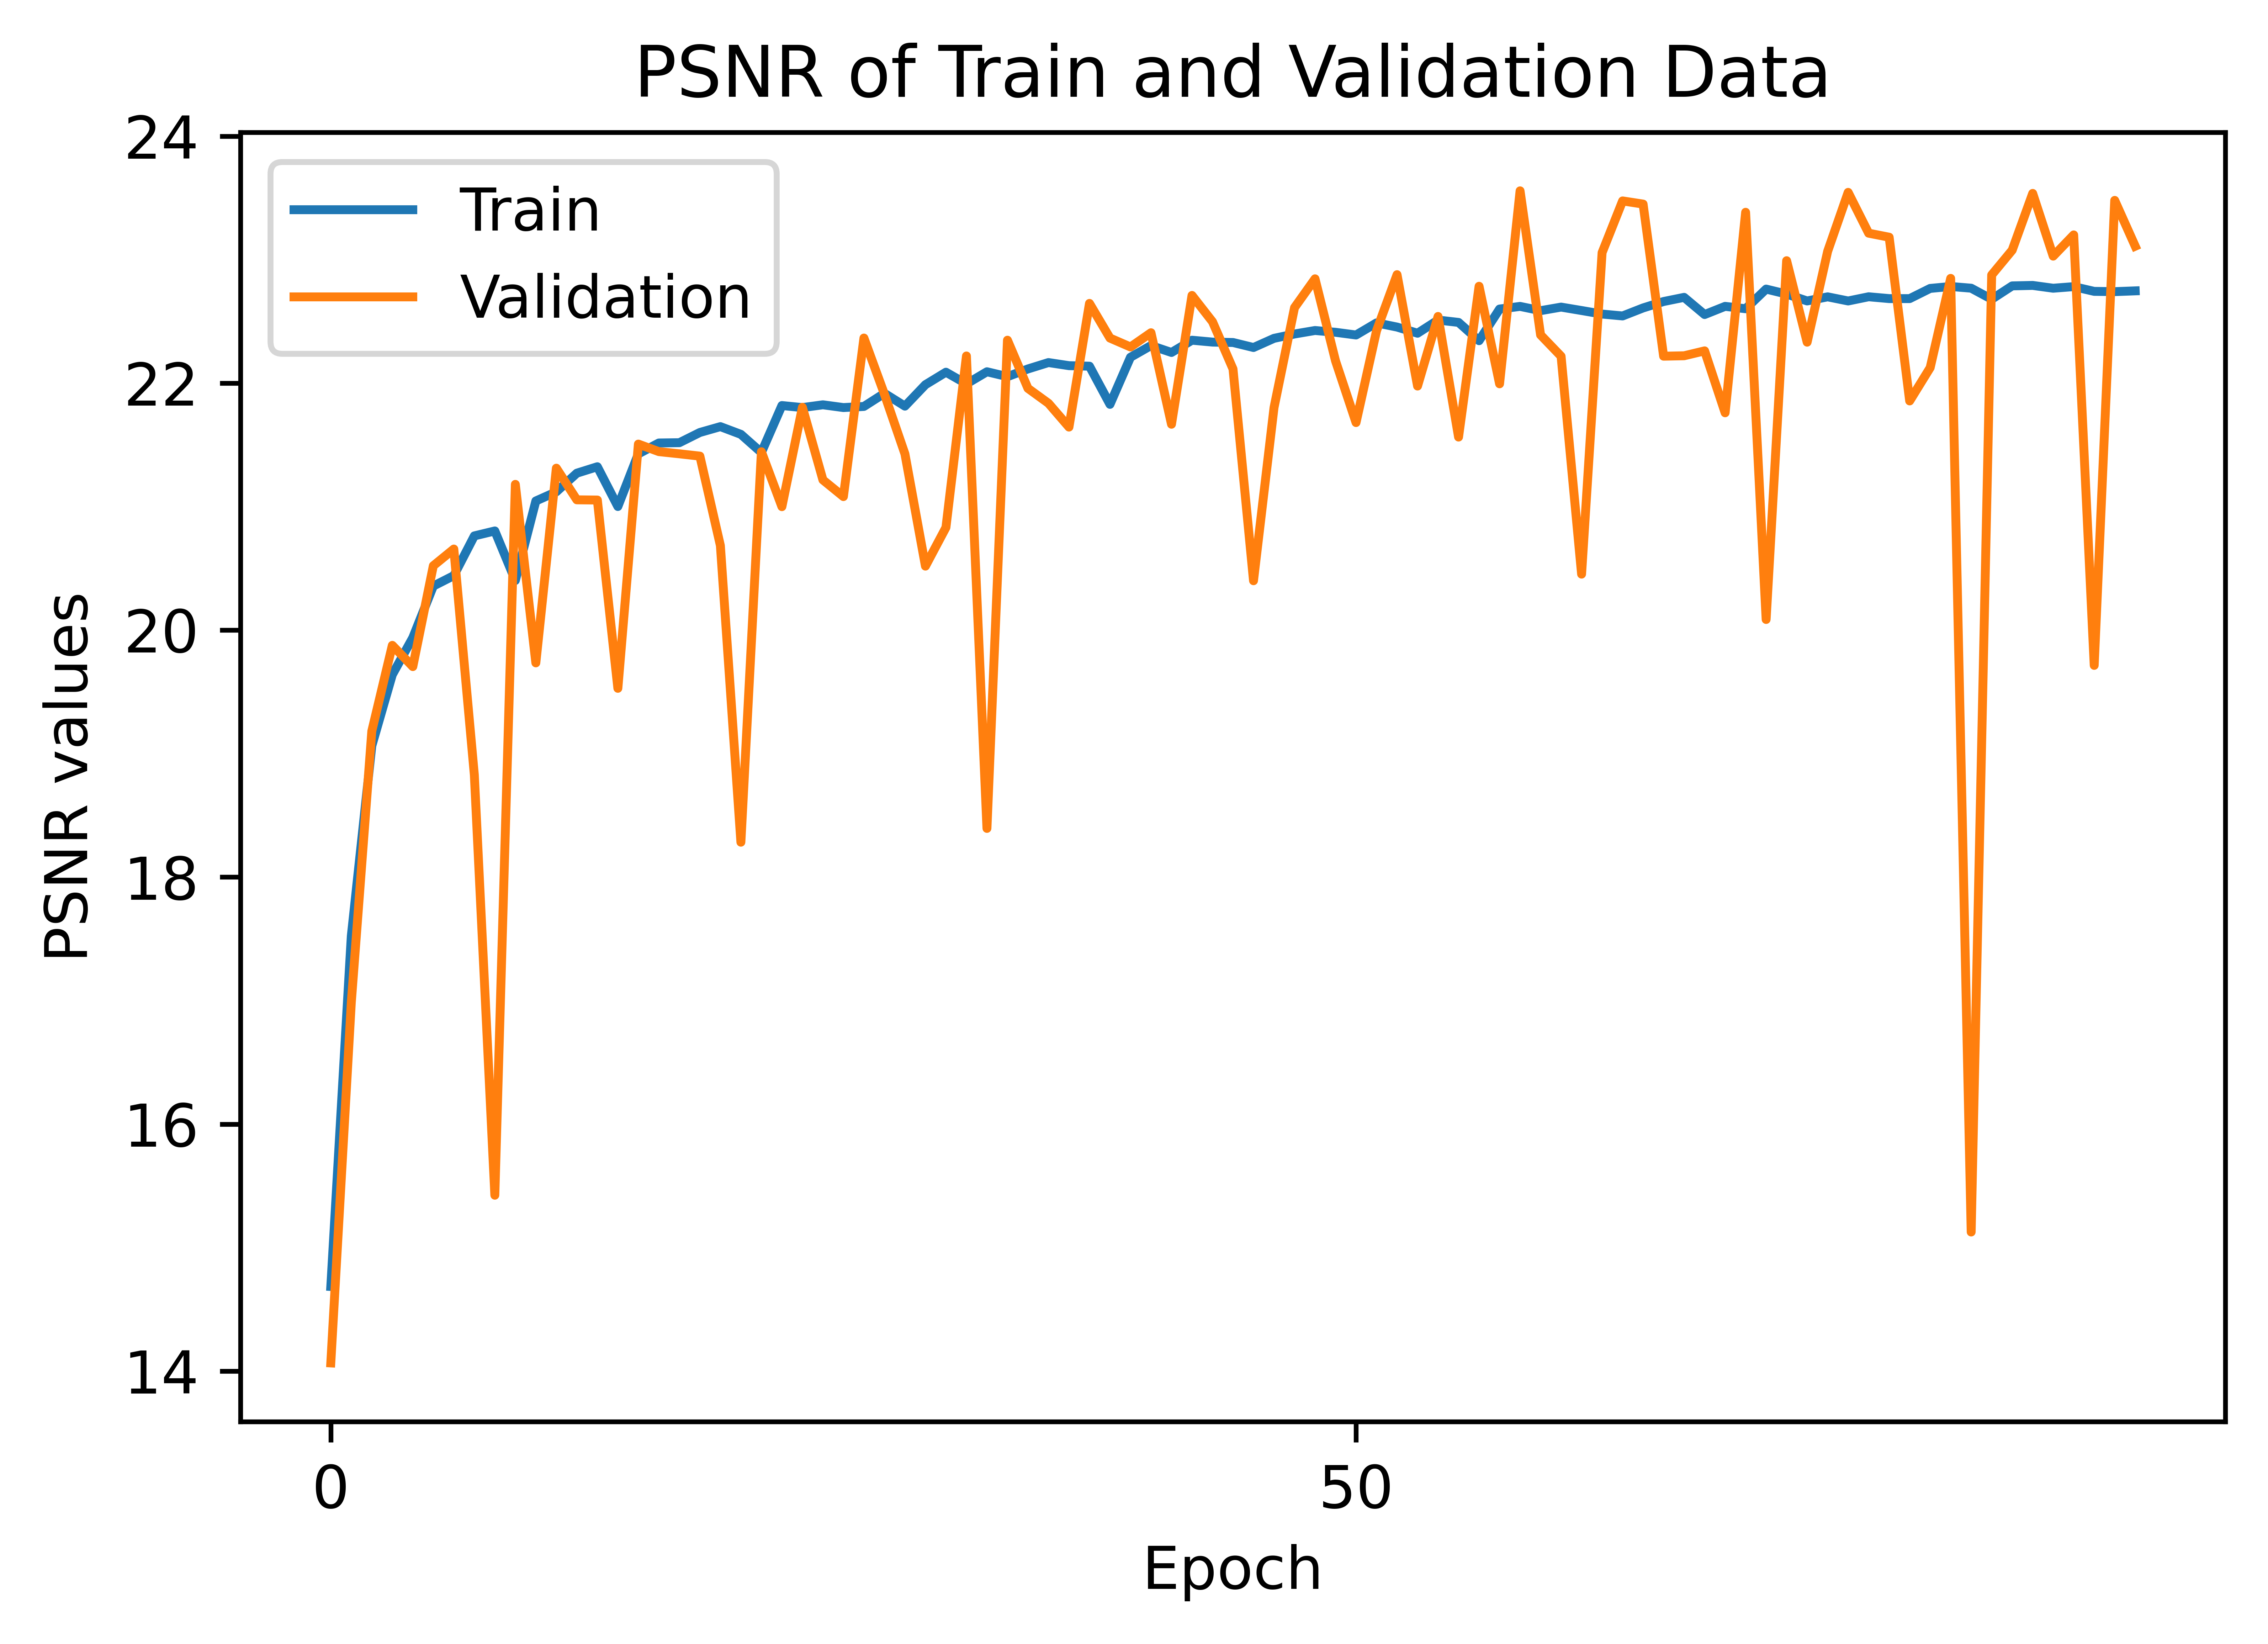

In [12]:
if __name__ == "__main__":
    start_training()